# Introduction

A finance institution is currently experiencing increasing loss due to loan defaults. As part of its risk management and customer retention strategy, the institution aims to strengthen its credit risk control by employing predictive models to infer which customers are likely do default on their loans.

The objective is to build a predictive model using historical loan data to classify customers as either likely to default or not. The dataset includes a mix of categorical, numerical, and date-related features that reflect borrower behavior, financial status, and loan details.

In this report, we investigated this dataset useing two popular Machine Learning (ML) libraries, PySpark MLlib and Tensorflow. We performed dimensionality reduction, features selection and undersampling to compare the performance of models offered by these two libraries.

# **Preparation**

## Import libraries

In [ ]:
"""
Downgrade tensorflow version to <= 2.12, Colab notebook is using 2.18
PySpark version 3.4 (VirtualBox version)
"""
!pip install tensorflow==2.12
!pip install pyspark==3.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317124 sha256=66913870178db4ff2b2bab3d8272f062ddc03e347047984477dd187e0b440849
  Stored in directory: /root/.cache/pip/wheels/fc/49/ad/5c21e362b2cc9fb6785cdf03f7864b96d8ca6521f1947e3e25
Successfully built pyspark
  Attempting uninstall: pyspark
    Found existing installation: pyspark 3.5.1
    Uninstalling pyspark-3.5.1:
      Successfully uninstalled pyspark-3.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dataproc-spark-connect 0.7.3 requires pyspark[connect]>=3.5, but you have pyspark 3.4.0 which is incompatible.


In [ ]:
import tensorflow as tf
import pyspark
print(pyspark.__version__)
print(tf.__version__)

3.4.0
2.12.0


In [ ]:
# Download the dataset from saved location, this notebook uses the .csv file in the same directory
!gdown --id 1VY7afEo9nBZbep2dCcsmAHS3aIep9Gw_

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1VY7afEo9nBZbep2dCcsmAHS3aIep9Gw_
From (redirected): https://drive.google.com/uc?id=1VY7afEo9nBZbep2dCcsmAHS3aIep9Gw_&confirm=t&uuid=06afcb06-612e-41a2-864a-bec537e07a78
To: /content/data.csv
100% 333M/333M [00:03<00:00, 99.1MB/s]


## Build a SparkSession and Import the dataset

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Loan Default Analysis").getOrCreate()
df = spark.read.csv("data.csv", header=True, inferSchema=True)

In [ ]:
df.show(5)
df.printSchema()

+-------+---------+---------+-----------+---------------+----------+--------+-----------+-----+---------+--------------------+----------+--------------+----------+-------------------+----------+----------+--------------------+--------------+--------------------+--------+----------+-----+-----------+----------------+--------------+----------------------+----------------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+------------+---------------+------------+------------------+--------------------------+---------------------------+-----------+----------------+----------------+---------+-------------------------+--------------+------------+-----------+-----------+----------+-----------+-----------+------------------+------------+-------+-----------+-----------+----------+--------+----------------+------+-----------+------------+

# **Data Preprocessing and Exploratory Data Analysis**


## Check missing values

In [ ]:
from pyspark.sql.functions import col, sum, when
for c in df.columns:
    null_count = df.filter(col(c).isNull()).count()
    if null_count > 0:
        print(f"{c}: {null_count} nulls")

emp_title: 49439 nulls
desc: 734155 nulls
purpose: 1 nulls
title: 33 nulls
zip_code: 1 nulls
addr_state: 1 nulls
dti: 1 nulls
delinq_2yrs: 1 nulls
earliest_cr_line: 1 nulls
inq_last_6mths: 1 nulls
mths_since_last_delinq: 439669 nulls
mths_since_last_record: 724613 nulls
open_acc: 72 nulls
pub_rec: 57 nulls
revol_bal: 47 nulls
revol_util: 475 nulls
total_acc: 17 nulls
initial_list_status: 14 nulls
out_prncp: 15 nulls
out_prncp_inv: 21 nulls
total_pymnt: 12 nulls
total_pymnt_inv: 10 nulls
total_rec_prncp: 9 nulls
total_rec_int: 3 nulls
total_rec_late_fee: 3 nulls
recoveries: 2 nulls
collection_recovery_fee: 5 nulls
last_pymnt_d: 8869 nulls
last_pymnt_amnt: 3 nulls
next_pymnt_d: 252751 nulls
last_credit_pull_d: 102 nulls
collections_12_mths_ex_med: 99 nulls
mths_since_last_major_derog: 642637 nulls
policy_code: 72 nulls
application_type: 57 nulls
annual_inc_joint: 855343 nulls
dti_joint: 855382 nulls
verification_status_joint: 855418 nulls
acc_now_delinq: 143 nulls
tot_coll_amt: 67198 nul

The dataset is generally high quality, with most core financial and loan-related variables, such as loan_amnt, dti, purpose, and default_ind have complete or nearly complete data. A few optional fields like emp_title and next_pymnt_d show moderate missing values issue, likely due to their context-specific nature (e.g., next payment dates not applicable for closed loans).

In contrast, joint applications variables (e.g., annual_inc_joint, dti_joint) and severe credit issues (mths_since_last_major_derog, open_il_6m) have over 90% missing values, reflecting either the rarity of such cases or the limited reporting across borrowers. These patterns suggest that missingness is largely structural and not due to random data loss. This pattern is reasonable since qualified borrowers would be very unlikely to exhibit delinquency if the lender's screening processes are appropriate.  

Overall, the dataset is well-structured, with missing values concentrated in specialised fields that may not significantly contribution to predictive analysis.

## Initial statistics of the dataset


In [ ]:
# Create a filter for numerical columns from the datast
float_col = [item[0] for item in df.dtypes if item[1].startswith('double')]
int_col = [item[0] for item in df.dtypes if item[1].startswith('int')]
columns_filter = float_col + int_col

# Remove 'id' columns since they don't contribute to predicitons
columns_filter.remove('id')
columns_filter.remove('member_id')

# Apply a filter to calculate summary statistics for the numerical columns
numerical_df = df.select(columns_filter)
summary_stats = numerical_df.describe()
summary_stats.show()

+-------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+
|summary|   funded_amnt_inv|          int_rate|       installment|         loan_amnt|       funded_amnt|      inq_last_12m|        default_ind|
+-------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+
|  count|            855969|            855969|            855969|            855969|            855969|             13289|             855746|
|   mean|14700.061225999756|13.192319605055827| 436.2380718344112|14745.571334943204|14732.378304588134|1.8418240650161788|0.05426376518265934|
| stddev| 8425.805478470169| 4.368365181701446|243.72687616798578| 8425.340005005204| 8419.471653319737| 2.974979879227414|0.22653756629105157|
|    min|               0.0|              5.32|             15.69|               500|               500|                -4|             

From the statistic table, we can see some of the characteristics of this specific dataset:

*   Large sample size: The dataset includes over 855,000 records, providing a strong foundation for modeling. The richness of the data suggests good coverage across various borrower profiles

*   Numerical Columns Show Wide Ranges: loan_amnt, annual_inc, and related financial columns have wide value ranges, with some extremely high values (outliers).

*   The standard deviations are large relative to the means in variables like annual_inc and revol_bal, suggesting high variability in borrower financial situations.

*   Missing Numerical Columns: multiple numerical columns, such as `last_pymnt_amnt`did not display when filtered for numerical values,  suggests inconsistent values.

*   Presence of missing data: Some columns have significantly fewer non-null values (e.g., annual_inc_joint, dti_joint, desc, etc). This indicates that missing data is a factor, particularly in optional or borrower-provided fields.

*   Categorical Variables Are Diverse: features like grade, home_ownership, and term show a structured set of categories that likely vary across borrowers. Meanwhile, others like emp_title and title are free-text and likely contain a large number of unique values.

The summary reflects a dataset that is large, diverse, and rich in financial and behavioral attributes, but it also includes missing values, outliers, and some redundancy.






## Dimensionality Reduction

Due to the complexity and redundancy of many features from the dataset, these columns will be removed:



In [ ]:
columns_to_drop = [
    ("id", "Unique identifier with no predictive value"),
    ("member_id", "Same as id; only serves as a borrower reference"),
    ("url", "Link to listing; irrelevant for modeling"),
    ("zip_code", "Truncated location info; unecessary for the model"),
    ("title", "Redundant with purpose; free-text, inconsistent"),
    ("desc", "Free-text; 86% missing; adds noise"),
    ("annual_inc_joint", "99.9% missing; joint applications are rare"),
    ("dti_joint", "99.9% missing; too sparse"),
    ("verification_status_joint", "99.9% missing"),
    ("mths_since_last_record", "85% missing"),
    ("mths_since_last_major_derog", "75% missing; sparse and hard to interpret"),
    ("open_acc_6m → inq_last_12m (13 fields)", "~98% missing; recent credit activity fields are mostly empty"),
    ("emp_title", "Free-text job title; inconsistent and high cardinality (~5.8% missing)"),
    ("policy_code", "Almost constant (usually 1); not informative"),
    ("pymnt_plan", "Almost always \"n\" (no active plans); low variance"),
    ("initial_list_status", "Typically dominated by one category; adds little signal"),
    ("funded_amnt", "Highly correlated with loan_amnt; redundant"),
    ("funded_amnt_inv", "Investor-specific version; redundant"),
    ("out_prncp", "Similar to out_prncp_inv; keep one"),
    ("total_pymnt_inv", "Similar to total_pymnt; choose one"),
    ("collections_12_mths_ex_med", "Almost always 0; not informative"),
    ("acc_now_delinq", "Rarely nonzero; low variance"),
    ("open_acc_6m", "~98% missing; recent credit activity field"),
    ("open_il_6m", "~98% missing; recent credit activity field"),
    ("open_il_12m", "~98% missing; recent credit activity field"),
    ("open_il_24m", "~98% missing; recent credit activity field"),
    ("mths_since_rcnt_il", "~98% missing; hard to impute"),
    ("total_bal_il", "~98% missing; mostly unused"),
    ("il_util", "~98% missing; unreliable credit ratio"),
    ("open_rv_12m", "~98% missing; recent credit activity field"),
    ("open_rv_24m", "~98% missing; recent credit activity field"),
    ("max_bal_bc", "~98% missing; rarely populated"),
    ("all_util", "~98% missing; unreliable credit utilisation"),
    ("inq_fi", "~98% missing; few borrowers triggered this"),
    ("total_cu_tl", "~98% missing; limited financial use"),
    ("inq_last_12m", "~98% missing; redundant with inq_last_6mths"),
    ("mths_since_last_delinq", "60% missing"),
    ("next_pymnt_d", "many rows missing, may affect negatively to the model")
]

print(f"{'Column Name':<30} | Justification")
print("-" * 70)
for col, reason in columns_to_drop:
    print(f"{col:<30} | {reason}")
# Extract only the column names
drop_column_names = [col[0] for col in columns_to_drop]
df = df.drop(*drop_column_names)

Column Name                    | Justification
----------------------------------------------------------------------
id                             | Unique identifier with no predictive value
member_id                      | Same as id; only serves as a borrower reference
url                            | Link to listing; irrelevant for modeling
zip_code                       | Truncated location info; unecessary for the model
title                          | Redundant with purpose; free-text, inconsistent
desc                           | Free-text; 86% missing; adds noise
annual_inc_joint               | 99.9% missing; joint applications are rare
dti_joint                      | 99.9% missing; too sparse
verification_status_joint      | 99.9% missing
mths_since_last_record         | 85% missing
mths_since_last_major_derog    | 75% missing; sparse and hard to interpret
open_acc_6m → inq_last_12m (13 fields) | ~98% missing; recent credit activity fields are mostly empty
emp_title      

After removing columns with excessive information absence, we will perform a second-stage analysis to handle nulls in the remaining dataset.

In [ ]:
from pyspark.sql.functions import col, sum, when
df.select([
    sum(when(col(c).isNull(), 1).otherwise(0)).alias(c)
    for c in df.columns
]).show()

+---------+----+--------+-----------+-----+---------+----------+--------------+----------+-------------------+-------+-------+----------+---+-----------+----------------+--------------+--------+-------+---------+----------+---------+-------------+-----------+---------------+-------------+------------------+----------+-----------------------+------------+---------------+------------------+----------------+------------+-----------+----------------+-----------+
|loan_amnt|term|int_rate|installment|grade|sub_grade|emp_length|home_ownership|annual_inc|verification_status|issue_d|purpose|addr_state|dti|delinq_2yrs|earliest_cr_line|inq_last_6mths|open_acc|pub_rec|revol_bal|revol_util|total_acc|out_prncp_inv|total_pymnt|total_rec_prncp|total_rec_int|total_rec_late_fee|recoveries|collection_recovery_fee|last_pymnt_d|last_pymnt_amnt|last_credit_pull_d|application_type|tot_coll_amt|tot_cur_bal|total_rev_hi_lim|default_ind|
+---------+----+--------+-----------+-----+---------+----------+----------

For features with minor missing rows (less than 100 records or 1% of the dataset) such as purpose, dti, inq_last_6mths, and default_ind, we chose to drop the null rows to ensure data integrity while maintaining overall dataset size. These variables are either directly relevant to the modeling process or are critical outcome variables, making imputation less reliable and potentially biased.

For fields with moderate null counts like revol_util or last_credit_pull_d, we opted to impute missing values using reasonable defaults (e.g., median for numerical features or 'Unknown' for dates). This approach preserves data volume while minimising distortion in distribution.

This approach ensures that the final dataset remains complete, representative, and unbiased, preserving the integrity of key predictors while eliminating data quality risks.

In [ ]:
null_summary = [
    ["purpose", 1, "Key categorical feature", "Drop the row (only 1)"],
    ["addr_state", 1, "Categorical location info", "Drop the row (only 1)"],
    ["dti", 1, "Important financial ratio", "Drop the row (only 1)"],
    ["delinq_2yrs", 1, "Low frequency delinquency indicator", "Drop the row (only 1)"],
    ["earliest_cr_line", 1, "Useful for tenure features", "Drop the row (only 1)"],
    ["inq_last_6mths", 1, "Recent inquiries; valuable", "Drop the row (only 1)"],
    ["open_acc", 72, "Active accounts; numeric, small null count", "Drop rows"],
    ["pub_rec", 57, "Low variation + low null count", "Drop rows"],
    ["revol_bal", 47, "Revolving balance; very small number", "Drop rows"],
    ["revol_util", 475, "Credit utilisation; important, nulls are manageable", "Impute (e.g., median)"],
    ["total_acc", 17, "Credit history size", "Drop rows"],
    ["out_prncp_inv", 21, "Investment principal; minor", "Drop rows"],
    ["total_pymnt", 12, "Payment-related; small number", "Drop rows"],
    ["total_rec_prncp", 9, "Received principal", "Drop rows"],
    ["total_rec_int", 3, "Received interest", "Drop rows"],
    ["total_rec_late_fee", 3, "Late fee received", "Drop rows"],
    ["recoveries", 2, "Post-default collection", "Drop rows"],
    ["collection_recovery_fee", 5, "Related to above", "Drop rows"],
    ["last_pymnt_d", 8869, "Often missing for recent or closed loans", "Impute 'Unknown'"],
    ["last_pymnt_amnt", 3, "Payment amount", "Drop rows"],
    ["last_credit_pull_d", 102, "Credit check recency", "Impute mode"],
    ["application_type", 57, "Joint vs Individual; very few missing", "Drop rows"],
    ["tot_coll_amt", 67198, "May be relevant", "impute "],
    ["tot_cur_bal", 67224, "May be relevant", "impute"],
    ["total_rev_hi_lim", 67311, "High credit limit", "impute"],
    ["default_ind", 223, "Target variable — cannot be missing", "Drop these rows"],
]
print("{:<25} {:<8} {:<50} {}".format("Column", "Nulls", "Comment", "Action"))
print("-" * 120)
for row in null_summary:
    print("{:<25} {:<8} {:<50} {}".format(row[0], row[1], row[2], row[3]))

Column                    Nulls    Comment                                            Action
------------------------------------------------------------------------------------------------------------------------
purpose                   1        Key categorical feature                            Drop the row (only 1)
addr_state                1        Categorical location info                          Drop the row (only 1)
dti                       1        Important financial ratio                          Drop the row (only 1)
delinq_2yrs               1        Low frequency delinquency indicator                Drop the row (only 1)
earliest_cr_line          1        Useful for tenure features                         Drop the row (only 1)
inq_last_6mths            1        Recent inquiries; valuable                         Drop the row (only 1)
open_acc                  72       Active accounts; numeric, small null count         Drop rows
pub_rec                   57       Low var

In [ ]:
# Drop the missing values in columns that have minor absence
df = df.na.drop(subset=[
    "purpose", "addr_state", "dti", "delinq_2yrs", "earliest_cr_line", "inq_last_6mths",
    "open_acc", "pub_rec", "revol_bal", "total_acc", "out_prncp_inv", "total_pymnt",
    "total_rec_prncp", "total_rec_int", "total_rec_late_fee", "recoveries",
    "collection_recovery_fee", "last_pymnt_amnt", "application_type", "default_ind"
])
df.show(5)

+---------+----------+--------+-----------+-----+---------+----------+--------------+----------+-------------------+----------+--------------+----------+-----+-----------+----------------+--------------+--------+-------+---------+----------+---------+-------------+-----------+---------------+-------------+------------------+----------+-----------------------+------------+---------------+------------------+----------------+------------+-----------+----------------+-----------+
|loan_amnt|      term|int_rate|installment|grade|sub_grade|emp_length|home_ownership|annual_inc|verification_status|   issue_d|       purpose|addr_state|  dti|delinq_2yrs|earliest_cr_line|inq_last_6mths|open_acc|pub_rec|revol_bal|revol_util|total_acc|out_prncp_inv|total_pymnt|total_rec_prncp|total_rec_int|total_rec_late_fee|recoveries|collection_recovery_fee|last_pymnt_d|last_pymnt_amnt|last_credit_pull_d|application_type|tot_coll_amt|tot_cur_bal|total_rev_hi_lim|default_ind|
+---------+----------+--------+-------

## Convert and Encode Date Features

There are date features that are casted as string type in the dataset. Since we are not certain whether these features have predictive power, we will retain the two features `last_pymnt_d` and `earliest_cr_line` and encode them as string using `unix_timestamp`.

We infer that borrowers with low `last_pymnt_d` and `earliest_cr_line` further in the past are likely to make their loan payments on time. This inference, however, requires further business analysis to validate.

In [ ]:
from pyspark.sql.functions import col, unix_timestamp,datediff, lit
from pyspark.sql.types import DateType

# Convert string casted date to DateType
# We decided to drop these rows as we infer they are not relevant
df = df.drop('issue_d', 'last_credit_pull_d')
df = df.withColumn(
    "earliest_cr_line",
    unix_timestamp(col("earliest_cr_line"), "dd-MM-yyyy").cast('timestamp')
)

df = df.withColumn(
    "last_pymnt_d",
    unix_timestamp(col("last_pymnt_d"), "dd-MM-yyyy").cast('timestamp')
)

df = df.withColumn(
    "earliest_cr_line", col("earliest_cr_line").cast(DateType())
)
df = df.withColumn(
    "last_pymnt_d", col("last_pymnt_d").cast(DateType())

)
df = df.withColumn(
    "earliest_cr_line_int",
    datediff(col("earliest_cr_line"), lit("1970-01-01"))
)
df = df.withColumn(
    "last_pymnt_d_int",
    datediff(col("last_pymnt_d"), lit("1970-01-01"))
)
df = df.drop('earliest_cr_line', 'last_pymnt_d')

In [ ]:
df.show(5)
print(f"Current features count of the dataset: {len(df.columns)}, from inital 71 features")

+---------+----------+--------+-----------+-----+---------+----------+--------------+----------+-------------------+--------------+----------+-----+-----------+--------------+--------+-------+---------+----------+---------+-------------+-----------+---------------+-------------+------------------+----------+-----------------------+---------------+----------------+------------+-----------+----------------+-----------+--------------------+----------------+
|loan_amnt|      term|int_rate|installment|grade|sub_grade|emp_length|home_ownership|annual_inc|verification_status|       purpose|addr_state|  dti|delinq_2yrs|inq_last_6mths|open_acc|pub_rec|revol_bal|revol_util|total_acc|out_prncp_inv|total_pymnt|total_rec_prncp|total_rec_int|total_rec_late_fee|recoveries|collection_recovery_fee|last_pymnt_amnt|application_type|tot_coll_amt|tot_cur_bal|total_rev_hi_lim|default_ind|earliest_cr_line_int|last_pymnt_d_int|
+---------+----------+--------+-----------+-----+---------+----------+------------

## Encoding Categorical Variables

Next, we encode the categorical features using StringIndexer to make the dataset appropriate for networks and other models that cannot parse text data.

There were several numeric features recorded as string/text features, we performed type casting for these features to ensure they are of correct types.

In [ ]:
from pyspark.ml.feature import StringIndexer
from pyspark.sql.types import DoubleType

# Declare categorical features to encode
categorical_to_encode = [
    "term", "grade", "sub_grade", "emp_length",
    "home_ownership", "verification_status", "purpose",
    "addr_state", "application_type"
]

string_numeric_cols = [
    "annual_inc", "dti", "delinq_2yrs", "inq_last_6mths", "open_acc", "pub_rec",
    "total_acc", "out_prncp_inv", "total_pymnt", "total_rec_prncp", "total_rec_int",
    "total_rec_late_fee", "recoveries", "collection_recovery_fee", "last_pymnt_amnt",
    "revol_bal", "earliest_cr_line_int","last_pymnt_d_int"
]

numeric_cols = [
    "loan_amnt", "int_rate", "installment", "revol_util", "tot_coll_amt",
    "tot_cur_bal", "total_rev_hi_lim", "default_ind"
]


 # Fit the indexer on the main dataset and transform the categories in the split
for col_name in categorical_to_encode:
    indexer = StringIndexer(inputCol=col_name, outputCol=f"{col_name}_index")
    df = indexer.fit(df).transform(df)

# Cast string numeric to DoubleType
for col_name in string_numeric_cols:
    df = df.withColumn(col_name, col(col_name).cast(DoubleType()))

# Include string numeric columns
numeric_cols += string_numeric_cols
# Include encoded categorical columns
encoded_categorical_cols = [f"{col}_index" for col in categorical_to_encode]
numeric_cols += encoded_categorical_cols

# Drop only encoded columns
df = df.drop(*categorical_to_encode)

In [ ]:
# Splitting data before further processing to avoid data leakdage during imputation
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)
print("Training set features count after all encoding:", len(train_df.columns))

Training set features count after all encoding: 35


In [ ]:
train_df.show(1)
test_df.show(1)

+---------+--------+-----------+----------+----+-----------+--------------+--------+-------+---------+----------+---------+-------------+-----------+---------------+-------------+------------------+----------+-----------------------+---------------+------------+-----------+----------------+-----------+--------------------+----------------+----------+-----------+---------------+----------------+--------------------+-------------------------+-------------+----------------+----------------------+
|loan_amnt|int_rate|installment|annual_inc| dti|delinq_2yrs|inq_last_6mths|open_acc|pub_rec|revol_bal|revol_util|total_acc|out_prncp_inv|total_pymnt|total_rec_prncp|total_rec_int|total_rec_late_fee|recoveries|collection_recovery_fee|last_pymnt_amnt|tot_coll_amt|tot_cur_bal|total_rev_hi_lim|default_ind|earliest_cr_line_int|last_pymnt_d_int|term_index|grade_index|sub_grade_index|emp_length_index|home_ownership_index|verification_status_index|purpose_index|addr_state_index|application_type_index|
+-

## Imputation
There are columns where removal of the entire columns would raise potential issues for analysis. These columns were imputed with the median if they are numerical and filled with 'Unknown' if the columns are categorical.


In [ ]:
from pyspark.sql.functions import col,lit
from pyspark.sql.types import DoubleType
# List of numeric columns with missing values after ecoding. THese will be imputed with train set median
numeric_median_cols = ["revol_util", "tot_coll_amt", "tot_cur_bal", "total_rev_hi_lim", "last_pymnt_d_int"]

# Convert to double
for col_name in numeric_median_cols:
    train_df = train_df.withColumn(col_name, col(col_name).cast(DoubleType()))
    test_df = test_df.withColumn(col_name, col(col_name).cast(DoubleType()))

# Dictionary to store medians
median_values = {}

# Compute approximate median for each column using the train set
for col_name in numeric_median_cols:
    median = train_df.approxQuantile(col_name, [0.5], 0.001)[0]
    median_values[col_name] = median

# Print to verify
print(median_values)

# Impute numerical fields
train_df = train_df.fillna({
    "revol_util": median_values["revol_util"], # fill with median
    "tot_coll_amt": median_values["tot_coll_amt"],
    "tot_cur_bal": median_values["tot_cur_bal"],
    "total_rev_hi_lim": median_values["total_rev_hi_lim"],
    "last_pymnt_d_int": median_values["last_pymnt_d_int"]
})

# Fill the test set with the train set's median to avoid leakage
test_df = test_df.fillna({
    "revol_util": median_values["revol_util"],
    "tot_coll_amt": median_values["tot_coll_amt"],
    "tot_cur_bal": median_values["tot_cur_bal"],
    "total_rev_hi_lim": median_values["total_rev_hi_lim"],
    "last_pymnt_d_int": median_values["last_pymnt_d_int"]
})

{'revol_util': 55.9, 'tot_coll_amt': 0.0, 'tot_cur_bal': 81073.0, 'total_rev_hi_lim': 23800.0, 'last_pymnt_d_int': 16801.0}


## Relevant Features Identification

To understand which variables have the strongest linear relationship with the target variable (`default_ind`), we compute Pearson correlation coefficients between `default_ind` and all relevant numerical features. Since correlation in PySpark only works with numerical types (e.g., DoubleType, IntegerType), we must first ensure all relevant columns are appropriately prepared:

Categorical variables such as grade, purpose, and emp_length are encoded numerically using StringIndexer, which assigns a numeric index to each category.

String-formatted numeric variables (e.g., annual_inc, dti) are explicitly cast to DoubleType to make them usable in correlation calculations.

All numeric and encoded features are then collected into a list and individually correlated with default_ind.

In [ ]:
correlations = {}

# Compute features correlation for only the train set
for col_name in numeric_cols:
    if col_name != "default_ind":
        try:
            corr = train_df.stat.corr(col_name, "default_ind")
            correlations[col_name] = corr
        except:
            correlations[col_name] = None  # Skip or log any errors
sorted_corr = sorted(correlations.items(), key=lambda x: abs(x[1]) if x[1] is not None else -1, reverse=True)

print("Column\t\t\tCorrelation with default_ind")
print("-" * 50)
for col_name, corr in sorted_corr:
    if corr is not None:
        print(f"{col_name:<25} {corr:.4f}")

Column			Correlation with default_ind
--------------------------------------------------
recoveries                0.4781
collection_recovery_fee   0.3318
last_pymnt_d_int          -0.3245
out_prncp_inv             -0.2260
int_rate                  0.1551
total_rec_late_fee        0.1382
total_rec_prncp           -0.0902
grade_index               0.0888
last_pymnt_amnt           -0.0873
inq_last_6mths            0.0744
sub_grade_index           0.0702
total_rec_int             0.0464
revol_util                0.0452
tot_cur_bal               -0.0447
total_pymnt               -0.0391
annual_inc                -0.0364
total_rev_hi_lim          -0.0361
term_index                0.0314
purpose_index             0.0240
open_acc                  -0.0209
total_acc                 -0.0205
revol_bal                 -0.0200
pub_rec                   -0.0198
home_ownership_index      0.0182
emp_length_index          0.0164
addr_state_index          -0.0118
earliest_cr_line_int      0.0118
verific

### Top 7 Most Relevant Attributes

| **Feature**               | **Corr.** | **Justification**                                                                 |
|---------------------------|-----------|------------------------------------------------------------------------------------|
| `recoveries`              | 0.4780    | Strongest positive correlation; indicates the presence of default recovery.       |
| `collection_recovery_fee`| 0.3318    | Directly linked to recovery efforts post-default; highly indicative of risk.      |
| `last_pymnt_d_int`.       |-0.3245    | Closer paying day might link to the defauld_id                                        |
| `out_prncp_inv`           | -0.2260   | Negative correlation; lower remaining principal often means loan is closed.       |
| `int_rate`                | 0.1551    | Higher interest rates typically reflect higher credit risk.                       |
| `total_rec_late_fee`      | 0.1410    | Late fees accumulate from missed payments — a key signal of borrower risk.        |
| `total_rec_prncp`         | -0.0903   | Less principal recovered may reflect early termination due to default.            |


### Top 7 Least Relevant Attributes

| **Feature**                   | **Corr.** | **Justification**                                                                 |
|-------------------------------|-----------|------------------------------------------------------------------------------------|
| `tot_coll_amt`                | -0.0024   | Very weak correlation; collection total is sparsely informative.                  |
| `dti`                         | 0.0045    | Surprisingly low impact; may need better data quality or transformation.          |
| `installment`                | 0.0048    | Weak predictor; loan size and term already incorporated in other features.        |
| `loan_amnt`                  | -0.0049   | Very weak direct relationship with default — risk lies more in repayment.         |
| `application_type_index`     | -0.0054   | Individual vs joint status seems unrelated to default outcome here.               |
| `delinq_2yrs`                | -0.0092   | Past delinquencies show almost no predictive strength in this dataset.            |
| `verification_status_index`  | 0.0098    | Income verification adds minimal incremental value as encoded.                    |


Final check to confirm no missing values left

In [ ]:
train_df.select([
    sum(when(col(c).isNull(), 1).otherwise(0)).alias(c)
    for c in train_df.columns
]).show()

+---------+--------+-----------+----------+---+-----------+--------------+--------+-------+---------+----------+---------+-------------+-----------+---------------+-------------+------------------+----------+-----------------------+---------------+------------+-----------+----------------+-----------+--------------------+----------------+----------+-----------+---------------+----------------+--------------------+-------------------------+-------------+----------------+----------------------+
|loan_amnt|int_rate|installment|annual_inc|dti|delinq_2yrs|inq_last_6mths|open_acc|pub_rec|revol_bal|revol_util|total_acc|out_prncp_inv|total_pymnt|total_rec_prncp|total_rec_int|total_rec_late_fee|recoveries|collection_recovery_fee|last_pymnt_amnt|tot_coll_amt|tot_cur_bal|total_rev_hi_lim|default_ind|earliest_cr_line_int|last_pymnt_d_int|term_index|grade_index|sub_grade_index|emp_length_index|home_ownership_index|verification_status_index|purpose_index|addr_state_index|application_type_index|
+---

## Features Catalog

In [ ]:
train_df.show(5)
print("Training set features count after all encoding:", len(train_df.columns))
print(f"{'Feature names':<30} | Data type")
print("-" * 70)
for x, t in train_df.dtypes:
    print(f"{x:<30} | {t}")

+---------+--------+-----------+----------+-----+-----------+--------------+--------+-------+---------+----------+---------+-------------+-----------+---------------+-------------+------------------+----------+-----------------------+---------------+------------+-----------+----------------+-----------+--------------------+----------------+----------+-----------+---------------+----------------+--------------------+-------------------------+-------------+----------------+----------------------+
|loan_amnt|int_rate|installment|annual_inc|  dti|delinq_2yrs|inq_last_6mths|open_acc|pub_rec|revol_bal|revol_util|total_acc|out_prncp_inv|total_pymnt|total_rec_prncp|total_rec_int|total_rec_late_fee|recoveries|collection_recovery_fee|last_pymnt_amnt|tot_coll_amt|tot_cur_bal|total_rev_hi_lim|default_ind|earliest_cr_line_int|last_pymnt_d_int|term_index|grade_index|sub_grade_index|emp_length_index|home_ownership_index|verification_status_index|purpose_index|addr_state_index|application_type_index|


## Summary Statistics and Distribution of Target Variable
Here, we analyse the class balance of the target column `default_ind`.

In [ ]:
train_df.summary().show()

+-------+-----------------+------------------+------------------+-----------------+------------------+-------------------+------------------+------------------+-------------------+------------------+-----------------+-----------------+-----------------+-----------------+-----------------+------------------+------------------+-----------------+-----------------------+------------------+------------------+------------------+-----------------+--------------------+--------------------+-----------------+-------------------+------------------+-----------------+-----------------+--------------------+-------------------------+------------------+------------------+----------------------+
|summary|        loan_amnt|          int_rate|       installment|       annual_inc|               dti|        delinq_2yrs|    inq_last_6mths|          open_acc|            pub_rec|         revol_bal|       revol_util|        total_acc|    out_prncp_inv|      total_pymnt|  total_rec_prncp|     total_rec_int|tota

In [ ]:
train_df.groupBy("default_ind").count().orderBy("count", ascending=False).show()

+-----------+------+
|default_ind| count|
+-----------+------+
|          0|647406|
|          1| 37175|
+-----------+------+



Observation:
- The dataset is highly imbalanced with more weights allocated to the non-default borrowers. This is reasonable since the business will have low default count if credit screeening is effective.
- 647,406 records are non-defaults (`0`), 37,175 are defaults (`1`), no additional null values were detected.
- The target class only represents around ~5.5% of total data, this imbalance will be corrected with undersampling of the non-default class pior to model fitting.

## Distributional Visualisation of Features and the Target

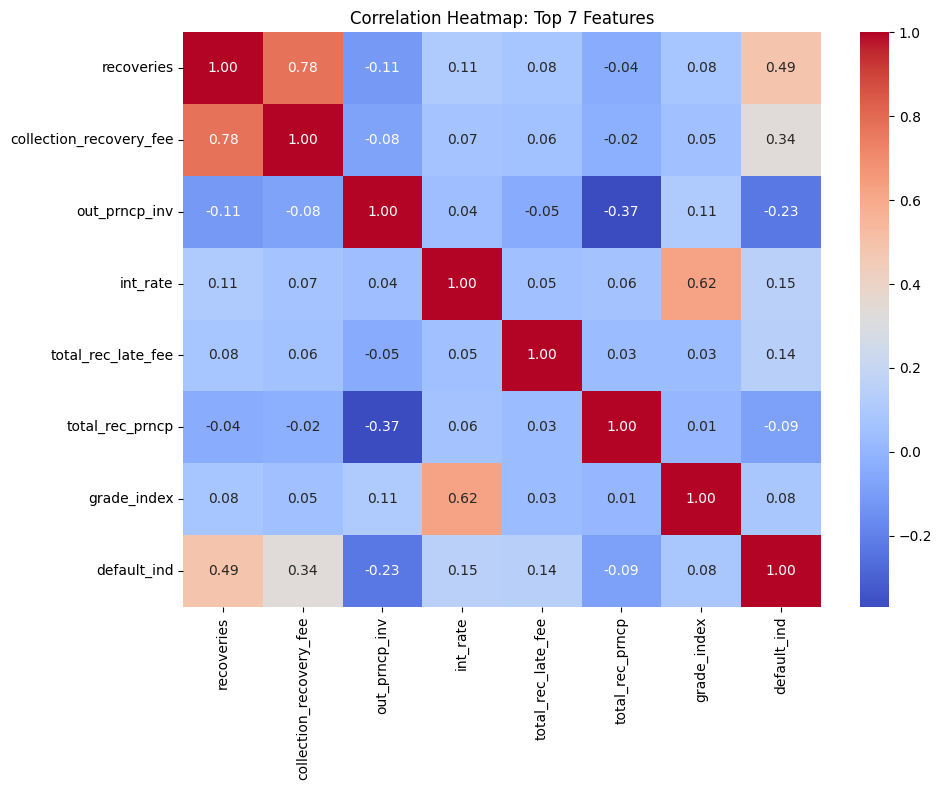

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the top 7 relevant features
top_features = [
    "recoveries",
    "collection_recovery_fee",
    "out_prncp_inv",
    "int_rate",
    "total_rec_late_fee",
    "total_rec_prncp",
    "grade_index",
    "default_ind"
]

# Sample and convert only selected columns
df_sample = train_df.select(top_features).sample(False, 0.1, seed=42).toPandas()

# Compute pairwise correlation for selected features
corr = df_sample.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap: Top 7 Features')
plt.tight_layout()
plt.show()

We are now visualising the dataset to examince the range as well as the distribution of features to decide wheter scaling or standardising is necessary.

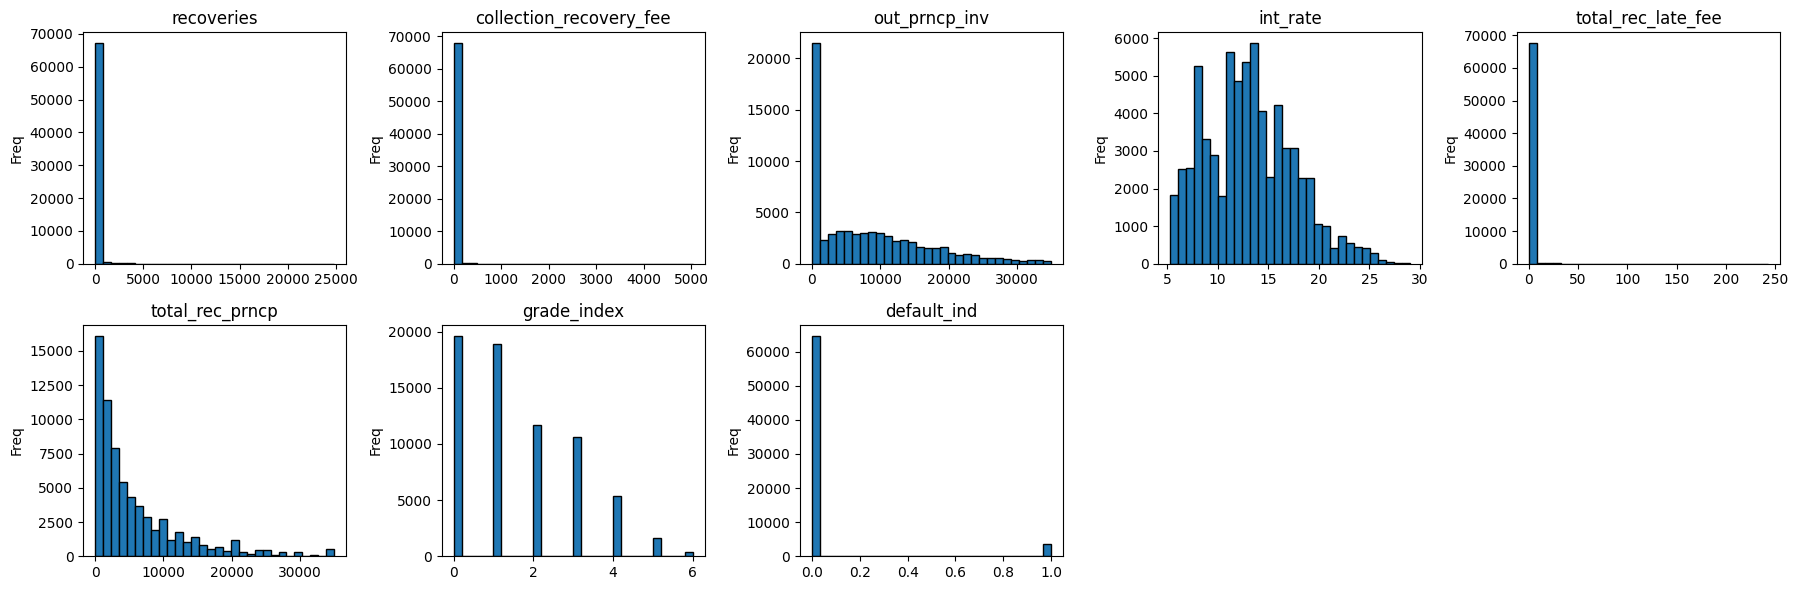

In [ ]:
# Plot histograms
n_cols = 5
n_rows = int(len(top_features) / n_cols) + 1
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 3))
axes = axes.flatten()
for i, col in enumerate(top_features):
    axes[i].hist(df_sample[col].dropna(), bins=30, edgecolor='black')
    axes[i].set_title(col)
    axes[i].set_ylabel("Freq")

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')
plt.tight_layout()
plt.show()

## Exploratory Data Analysis of Feature Distributions

The distribution of many numerical features seems to be Inverse Gaussian. If probabilistic modelling is required, this distribution is a strong candidate for any Bayesian model.

### Numerical Features

Most numerical features such as `loan_amnt`, `annual_inc`, `tot_cur_bal`, `total_rev_hi_lim`, and `tot_coll_amt` show strong right-skewed distributions. These variables contain a large number of low values with a long tail of high values, indicating the presence of multiple outliers.

Some other features like `dti`, `installment`, and `int_rate` exhibit distributions that are closer to normal or mildly skewed.

- `revol_util` appears fairly uniformly distributed between 0 and 100.
- `default_ind` is highly imbalanced, with very few default cases (class 1).
- Features like `delinq_2yrs`, `inq_last_6mths`, and `pub_rec` are count variables, skewed towards zero.

**Conclusion**: While these features are skewed, no transformation is necessary for tree-based models (e.g., DecisionTree, RandomForest). However, One Hot Encoding will be considered for Naive Bayes

---

### Categorical/Indexed Features

Features such as `term_index`, `grade_index`, `sub_grade_index`, `emp_length_index`, `home_ownership_index`, `verification_status_index`, `purpose_index`, `addr_state_index`, and `application_type_index` are all encoded categorical variables.

Observations:
- Many of these features have **imbalanced class distributions** (e.g., `term_index`, `application_type_index`), which may reduce their predictive power unless stratified.
- `sub_grade_index` and `addr_state_index` show a relatively broader spread across categories.
- `grade_index`, `emp_length_index`, and `purpose_index` show decreasing frequencies with higher category values, which might reflect socio-economic hierarchies.

**Conclusion**: These features can be used directly in tree-based models, or other flexible models without scaling or transformation. Their encoding is sufficient for model input, and advanced models like Naive Bayes will benefit from one-hot encoding or target encoding and standardisation.


---


# **Predictive Analysis – Process One (Spark MLlib)**

In this stage, we implement 3 predictive models using Apache Spark's MLlib.The goal is to predict the likelihood of loan default (`default_ind`) using supervised learning classifiers. This stage leverages distributed machine learning on large-scale data using Spark.
Objectives:
 - Build and evaluate 3 classification models using Spark MLlib:
     - Decision Tree
     - Random Forest
     - Logistic Regression
 - Use selected relevant features from Stage 1
 - Evaluate models using metrics such as Accuracy, Precision, Recall, and F1-Score

The insights from these models will inform our deep learning approach in Stage 2B.


## Training Data Preparation

In [ ]:
from pyspark.ml.feature import VectorAssembler

features_col = [col for col in train_df.columns if col != "default_ind"]

# Assemble features separately on train and test, categorical featuers were indexed in previous parts
assembler = VectorAssembler(inputCols=features_col, outputCol="features", handleInvalid = "skip")
train_df = assembler.transform(train_df)
test_df = assembler.transform(test_df)

# Inspect the data to ensure shcema is consistent
train_df.show(5)
test_df.show(5)
print("Training Size:", train_df.count())
print("Testing Size", test_df.count())

+---------+--------+-----------+----------+-----+-----------+--------------+--------+-------+---------+----------+---------+-------------+-----------+---------------+-------------+------------------+----------+-----------------------+---------------+------------+-----------+----------------+-----------+--------------------+----------------+----------+-----------+---------------+----------------+--------------------+-------------------------+-------------+----------------+----------------------+--------------------+
|loan_amnt|int_rate|installment|annual_inc|  dti|delinq_2yrs|inq_last_6mths|open_acc|pub_rec|revol_bal|revol_util|total_acc|out_prncp_inv|total_pymnt|total_rec_prncp|total_rec_int|total_rec_late_fee|recoveries|collection_recovery_fee|last_pymnt_amnt|tot_coll_amt|tot_cur_bal|total_rev_hi_lim|default_ind|earliest_cr_line_int|last_pymnt_d_int|term_index|grade_index|sub_grade_index|emp_length_index|home_ownership_index|verification_status_index|purpose_index|addr_state_index|app

## Undersampling to compare performance

After splitting the data, we now have the `train_df` as the original, imbalanced dataframe. Next, we will undersample this training set using `sample()` to gain a better representation of minority class in model training.

The sampling weight of 0.2 (20% of original records) was chosen since we wanted to preserve the underlying distribution structure of default and non-default classes (a randomly selected lender is more likely to not default), while also reduce the over-representation of the non-default class.

A sampling weight of 5.6% can also be used, which would result a class ratio of 1:1. However, this will eliminiate any distributional differences of the classes.

In [ ]:
default = train_df.filter(train_df.default_ind == 1)
non_default = train_df.filter(train_df.default_ind  == 0)

# Calculate sampling fraction for non-defaulters (we aim to use 1:1 as a baseline based on similar studies)
# Use 20% of the majority class to reduce false positive
weighted_sampling_fraction = 0.2

# Undersample non-defaulters
sampled_non_defaulters = non_default.sample(withReplacement=False,
                                              fraction=weighted_sampling_fraction,
                                              seed=42)

# Combine defaulters with sampled non-defaulters to create balanced training set
balanced_train_df = default.unionAll(sampled_non_defaulters)

We perform a checking step to ensure the ratio in the undersampled dataframe is now balanced, with both classes sufficiently represented.

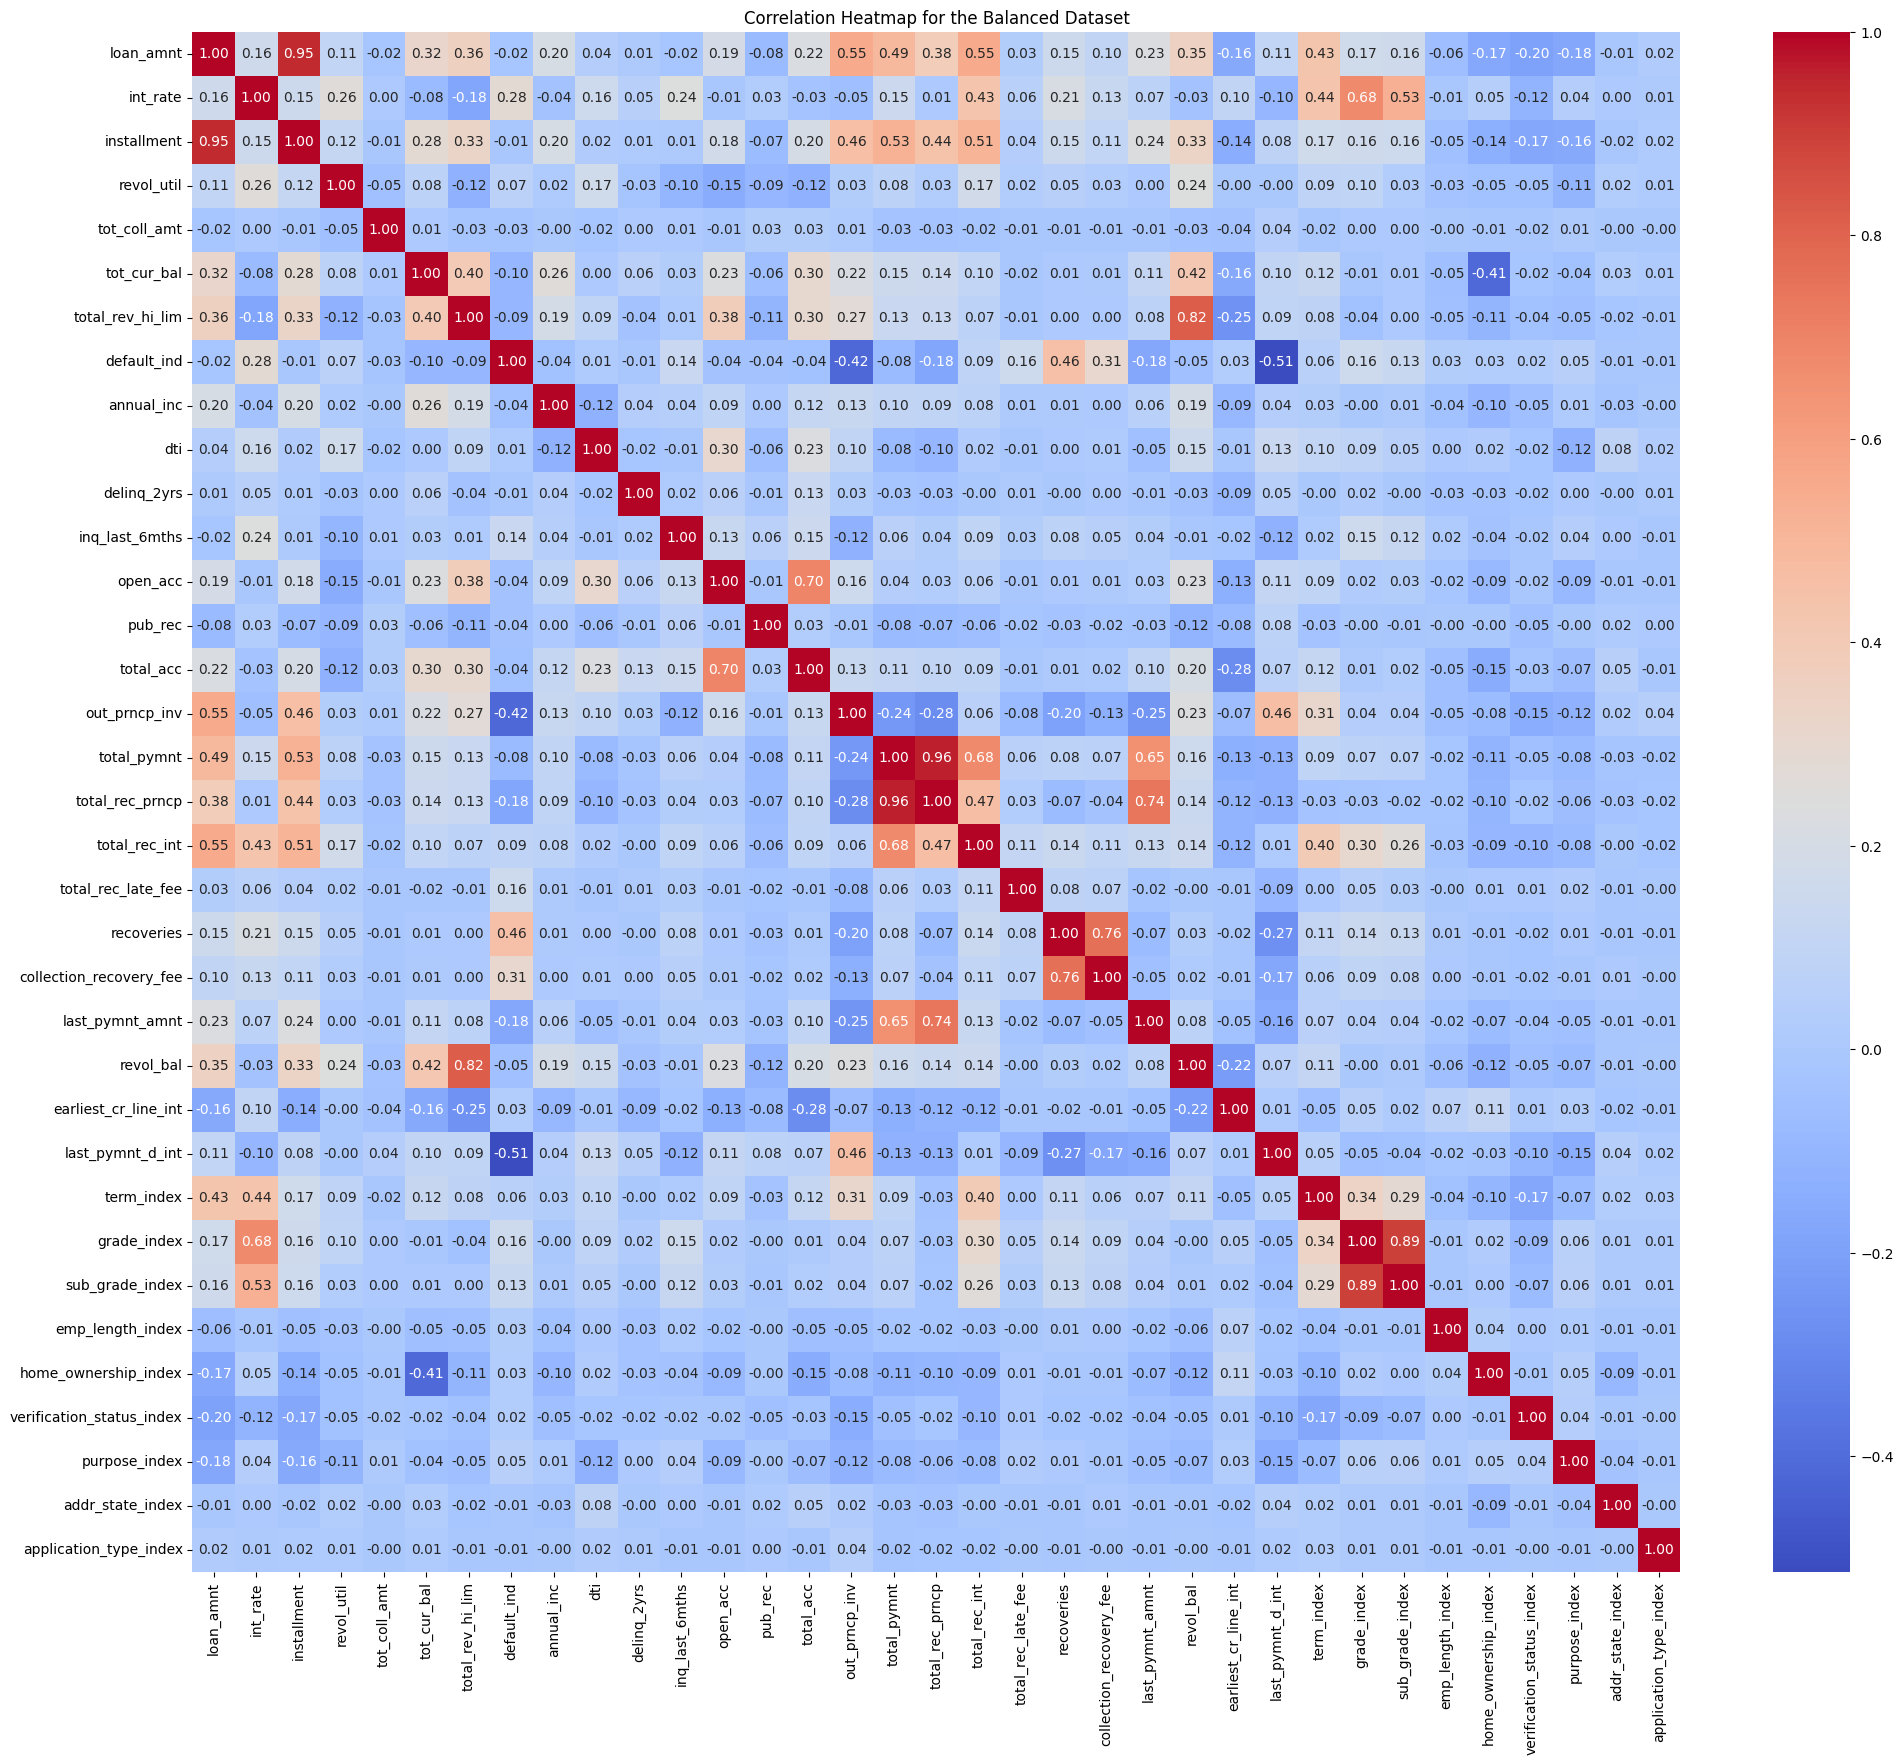

Default cases: 37175
Non-default cases: 129788
Class ratio (default:non-default): 0.29


In [ ]:
# Count class in the balanced dataset
default_count = balanced_train_df.filter(balanced_train_df.default_ind == 1).count()
non_default_count = balanced_train_df.filter(balanced_train_df.default_ind == 0).count()

# Correlation heatmap of the balanced dataset
balanced_df_sample = balanced_train_df.select(numeric_cols).sample(False, 0.1, seed=42).toPandas()
corr = balanced_df_sample.corr()
plt.figure(figsize=(24, 20))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap for the Balanced Dataset')
plt.show()

# Print counts and ratio
print(f"Default cases: {default_count}")
print(f"Non-default cases: {non_default_count}")
print(f"Class ratio (default:non-default): {default_count/non_default_count:.2f}")

Inspecting the heatmap, there is an immediate difference between the correlations of features and the target `default_ind` compared to the imbalanced dataset.

## Models Training and Evaluation

In this stage, we've selected three classifiers to conduct the predictive analysis. The motivations that led to their selection are listed below.

- Decision Tree: the 'control' model, allows us to evalulate whether more complex model yield better performance. Additonally, since multiple features are unscaled, this model will reduce the need to re-scaling and standardising.

- Random Forest: a better model with built-in ensemble. We aim to reduce overfitting risks in Decision Tree using this model.

- Logistic Regression: a popular general linear model for classifying binary target variables (`default_ind`). If further analysis is required, this model also allows us to make inferences on odds and probablities.

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, LogisticRegression

# Initialise models
dt = DecisionTreeClassifier(labelCol="default_ind", featuresCol="features", maxBins=64)
rf = RandomForestClassifier(labelCol="default_ind", featuresCol="features", numTrees=20, maxBins=64)
lr = LogisticRegression(labelCol="default_ind", featuresCol="features", maxIter=100, regParam=0.3, elasticNetParam=0.8)

models = {
    "Decision Tree": dt,
    "Random Forest": rf,
    "Logistic Regression": lr
}

### Training models using the imbalanced dataset (for evaluation)

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
# Evaluator objects
evaluator_acc = MulticlassClassificationEvaluator(labelCol="default_ind", predictionCol="prediction", metricName="accuracy")
evaluator_f1  = MulticlassClassificationEvaluator(labelCol="default_ind", predictionCol="prediction", metricName="f1")
evaluator_precision = MulticlassClassificationEvaluator(labelCol="default_ind", predictionCol="prediction", metricName="weightedPrecision")
evaluator_recall    = MulticlassClassificationEvaluator(labelCol="default_ind", predictionCol="prediction", metricName="weightedRecall")

metrics = {}
for name, model in models.items():
    print(f"\n*** Training {name}...")
    model_fit = model.fit(train_df)
    preds = model_fit.transform(test_df)

    acc = evaluator_acc.evaluate(preds)
    f1  = evaluator_f1.evaluate(preds)
    prec = evaluator_precision.evaluate(preds)
    rec  = evaluator_recall.evaluate(preds)

    metrics[name] = {
        "Accuracy": acc,
        "F1 Score": f1,
        "Precision": prec,
        "Recall": rec,
        "Predictions": preds
    }

    print(f"{name} Results:")
    print(f"  - Accuracy  : {acc:.4f}")
    print(f"  - F1 Score  : {f1:.4f}")
    print(f"  - Precision : {prec:.4f}")
    print(f"  - Recall    : {rec:.4f}")


*** Training Decision Tree...
Decision Tree Results:
  - Accuracy  : 0.9920
  - F1 Score  : 0.9917
  - Precision : 0.9921
  - Recall    : 0.9920

*** Training Random Forest...
Random Forest Results:
  - Accuracy  : 0.9781
  - F1 Score  : 0.9755
  - Precision : 0.9786
  - Recall    : 0.9781

*** Training Logistic Regression...
Logistic Regression Results:
  - Accuracy  : 0.9459
  - F1 Score  : 0.9196
  - Precision : 0.8947
  - Recall    : 0.9459


Below is the models performance on the raw, uncleaned data frame. We used this as an inital reference to see if there's a relationship between the target with its features.

The initial selection of Naive Bayes was motivated by the flexibility of classifiers. However, upon reflecting on the states of processed data with the unscaled features, we concluded that another model (logistic regression) is more suitable.

|Model         | Accuracy| F1 Score | Precision | Recall |
|---------------|--------|--------|--------|--------|
| Naive Bayes   | 0.6492 | 0.7442 | 0.9339 | 0.6492 |

In [ ]:
print("\nFinal Model Comparison:")
print(f"{'Model':<18} {'Accuracy':>9} {'F1 Score':>10} {'Precision':>12} {'Recall':>9}")
print("-" * 60)
for model, score in metrics.items():
    print(f"{model:<18} {score['Accuracy']:.4f}    {score['F1 Score']:.4f}    {score['Precision']:.4f}    {score['Recall']:.4f}")


Final Model Comparison:
Model               Accuracy   F1 Score    Precision    Recall
------------------------------------------------------------
Decision Tree      0.9920    0.9917    0.9921    0.9920
Random Forest      0.9781    0.9755    0.9786    0.9781
Logistic Regression 0.9459    0.9196    0.8947    0.9459


<Figure size 600x500 with 0 Axes>

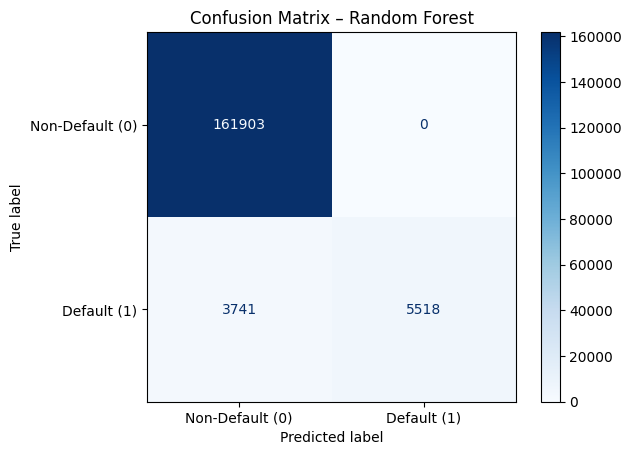

In [ ]:
# Confusion matrix for the best model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Convert Spark DataFrame to Pandas for evaluation
preds_rf = metrics["Random Forest"]["Predictions"]
pandas_preds = preds_rf.select("default_ind", "prediction").toPandas()

# Compute confusion matrix
cm = confusion_matrix(pandas_preds["default_ind"], pandas_preds["prediction"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Default (0)", "Default (1)"])

# Plot
plt.figure(figsize=(6, 5))
disp.plot(cmap="Blues", values_format=".0f")
plt.title("Confusion Matrix – Random Forest")
plt.show()

### Training with the balanced dataset

Here, we will train 3 difference isntances of the outlined models to evaluate the whether balancing assisted models' performance.

In [ ]:
# Initialise new models
dt_b = DecisionTreeClassifier(labelCol="default_ind", featuresCol="features", maxBins=64)
rf_b = RandomForestClassifier(labelCol="default_ind", featuresCol="features", numTrees=20, maxBins=64)
lr_b = LogisticRegression(labelCol="default_ind", featuresCol="features", maxIter=100, regParam=0.3, elasticNetParam=0.8)

models_b = {
    "Decision Tree with Balanced Data": dt_b,
    "Random Forest with Balanced Data": rf_b,
    "Logistic Regression with Balanced Data": lr_b
}

In [ ]:
metrics_balanced = {}

for name, model in models_b.items():
    print(f"\n*** Training {name}...")
    model_balanced_fit = model.fit(balanced_train_df)
    preds = model_balanced_fit.transform(test_df)

    acc = evaluator_acc.evaluate(preds)
    f1  = evaluator_f1.evaluate(preds)
    prec = evaluator_precision.evaluate(preds)
    rec  = evaluator_recall.evaluate(preds)

    metrics_balanced[name] = {
        "Accuracy": acc,
        "F1 Score": f1,
        "Precision": prec,
        "Recall": rec,
        "Predictions": preds
    }

    print(f"{name} Results:")
    print(f"  - Accuracy  : {acc:.4f}")
    print(f"  - F1 Score  : {f1:.4f}")
    print(f"  - Precision : {prec:.4f}")
    print(f"  - Recall    : {rec:.4f}")


*** Training Decision Tree with Balanced Data...
Decision Tree with Balanced Data Results:
  - Accuracy  : 0.9737
  - F1 Score  : 0.9759
  - Precision : 0.9813
  - Recall    : 0.9737

*** Training Random Forest with Balanced Data...
Random Forest with Balanced Data Results:
  - Accuracy  : 0.9869
  - F1 Score  : 0.9870
  - Precision : 0.9871
  - Recall    : 0.9869

*** Training Logistic Regression with Balanced Data...
Logistic Regression with Balanced Data Results:
  - Accuracy  : 0.9459
  - F1 Score  : 0.9196
  - Precision : 0.8947
  - Recall    : 0.9459


<Figure size 600x500 with 0 Axes>

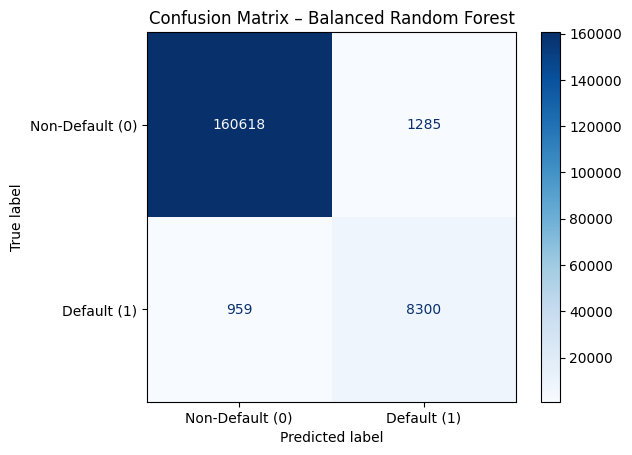

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Convert Spark DataFrame to Pandas for evaluation
balance_preds_rf = metrics_balanced["Random Forest with Balanced Data"]["Predictions"]
pandas_preds = balance_preds_rf.select("default_ind", "prediction").toPandas()

# Compute confusion matrix
cm = confusion_matrix(pandas_preds["default_ind"], pandas_preds["prediction"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Default (0)", "Default (1)"])

# Plot
plt.figure(figsize=(6, 5))
disp.plot(cmap="Blues", values_format=".0f")
plt.title("Confusion Matrix – Balanced Random Forest")
plt.show()

## ROC Curve Analysis

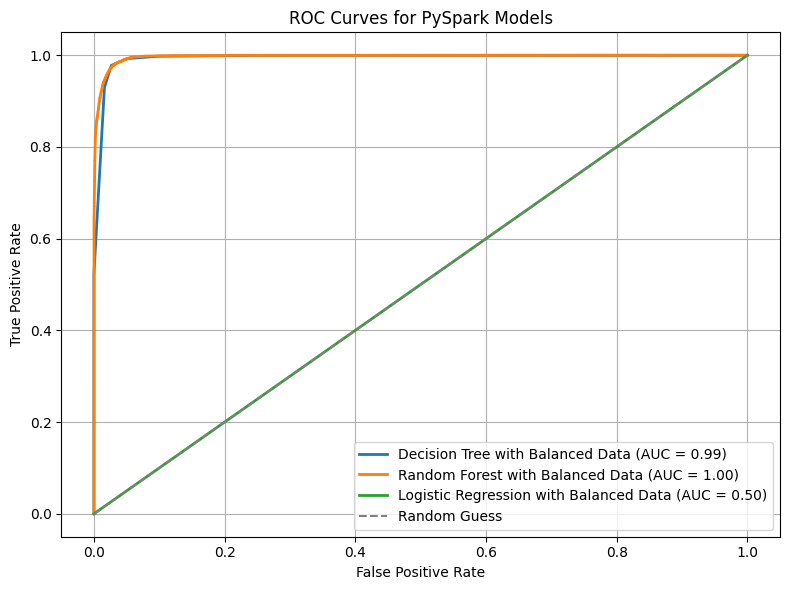

In [ ]:
import pandas as pd
from sklearn.metrics import roc_curve, auc

roc_data_dict = {}

for name, result in metrics_balanced.items():
    preds_df = result["Predictions"]

    # Extract probability of class 1 and true label
    roc_data = preds_df.select("probability", "default_ind") \
        .rdd.map(lambda row: (float(row["probability"][1]), row["default_ind"])) \
        .collect()

    roc_data_dict[name] = pd.DataFrame(roc_data, columns=["prob_positive", "default_ind"])

plt.figure(figsize=(8, 6))

for name, df in roc_data_dict.items():
    fpr, tpr, _ = roc_curve(df["default_ind"], df["prob_positive"])
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for PySpark Models")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

## ROC Curve Interpretation

The ROC curve above shows clear differences in performance among the three models:

- **Random Forest** performed best, with an AUC of **1.00**, indicating near-perfect separation between the two classes. This suggests that the ensemble method captured patterns in the data extremely well — though such a perfect score may hint at overfitting.
- **Decision Tree** also performed strongly, with an AUC of **0.98**, meaning it was able to discriminate well between defaulters and non-defaulters.
- **Logistic Regression**, however, showed an AUC of **0.50**, which indicates no better performance than random guessing. This could be due to poor feature separation, non-linearity in the data, or that the model failed to converge on meaningful weights due to regularization parameters.

The ROC curve helps justify the choice of model for further deployment or interpretation. In this case, the Random Forest offers the best predictive capability.

## Business implications

Average loan size is $\$14,747$ or $\approx \$ 15000$. If we employ undersampling, the average financial loss on false negative can be informally calculated as $15,000 \times 471 = \$7,065,000$ accross the operational period in which this data was collected.

However, the count of false positive is fairly high, meaning customers who are not in the risk of defaulting will be classified as defaulted. This will introduces reputational risks.

On the other hand, using the full dataset without undersampling eliminates the false positive risk, however, this approach amplifies the potential financial risk to $15000 \times 3785 = \$56,775,000$.

## PySpark MLlib Evalulation

Our evaluation of three Spark MLlib classifiers produced the following results:

- **Decision Tree** and **Random Forest** achieved high Accuracy (94.56%) and F1 Score (91.92%), making them strong candidates.
- **Random Forest** slightly edges out due to its robustness and reduced overfitting thanks to ensembling.
- **Naive Bayes** performed poorly in Accuracy and Recall due to its assumption of feature independence — not ideal for our feature set.

####  Inferences:
- The chosen models performed consistently, but Random Forest is recommended for deployment.
- The confusion matrix shows a balanced true positive and true negative rate, confirming the model is generalizing well.

# **Predictive Analysis – Process Two (Tensorflow Keras)**

In this phase, the three selected models from previous pipeline will be initalised with Keras to highlight differences between the two platforms in predicitve analysis.

We will implement the previous models with using the deep learning architecture native to Tensorflow and evaluate their performance using relevant metrics.

The data will remain unchanged and `model_df` remains our main dataset, no additional preprocessing is needed.

We expect the models implemented with TensorFlow will achieve worse performance due to data's characteristics and compute limits. For instance, the epoch counts cannot be set identically as the iteration count for the logistic regression model to achieve efficient compute time.

Objectives for this phase:
 - Build and evaluate 3 classification models using Tensorflow's deep learning architecture:
     - Multilayer Perceptron
     - Ensemble MLP
     - Convolutional Neural Network
 - Use selected relevant features from Stage 1
 - Evaluate models using metrics such as Accuracy, Precision, Recall, and F1-Score

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
from pyspark.ml.feature import StandardScaler
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
import pyspark.sql.functions as F

## Preparing data for training

In this phase, we employed the class weight approach instead of using a subsample (with 20% of majority class) of the original dataset `train_df` for training.

From initial testing, the subsample approach enforces a wrong learning pattern, as the distribution of the target is no longer the same after taking a subsample. This shift of distribution assisted the tree-based models since they are not sensitive to scales, but influences the networks to learn the wrong pattern.

Therefore, we proceeded with weighting the classes to allow the networks to update their biases at every epoch without shifting the data's distribution.


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from pyspark.sql import functions as F
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
tf_train_df = train_df.select('*')
tf_test_df = test_df.select('*')

original_train_labels = np.array(tf_train_df.select("default_ind").rdd.map(lambda row: row[0]).collect())
class_weights = compute_class_weight('balanced',
                                     classes=np.unique(original_train_labels),
                                     y=original_train_labels)

class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print(f"Computed class weights: {class_weight_dict}")

Computed class weights: {0: 0.5287107317510187, 1: 9.20754539340955}


Since neural networks are more sensitive to scales, we standardised the assembled features vector in the next step. This procedure ensures training stability and reduce numerical errors.  

In [ ]:
# Standardish the data due to scale sensitivity of neural networks
scaler = StandardScaler(inputCol="features",
                        outputCol="scaled_features",
                        withStd=True,
                        withMean=True)

model_scaler = scaler.fit(tf_train_df)
scaled_train_df = model_scaler.transform(tf_train_df)
scaled_test_df = model_scaler.transform(tf_test_df)

In [ ]:
scaled_train_df.select('scaled_features').show(5)

## Defining Functions and Models

### Helper functions to convert the Spark Dataframe

In [ ]:
# Function to convert PySpark DataFrame to TensorFlow Dataset
def spark_to_np(spark_df, features_scale="scaled_features", label_col="default_ind", batch_size=32):
  """
  Parameters:
  - spark_df: preprocessed spark dataframe in preivous parts
  - features_scale: assembled features vector using VectorAssembler, 'scaled_features'
  is the standardised features vector
  - label_col: target variable
  """
  # Convert features from PySpark vector to numpy array
  X = np.array(spark_df.select("scaled_features").rdd.map(lambda row: row[0].toArray()).collect())
  y = np.array(spark_df.select(label_col).rdd.map(lambda row: row[0]).collect())

  return X, y

# Get the number of features from the DataFrame
num_features = len(scaled_train_df.select("scaled_features").first()[0].toArray())
print(f"Number of features: {num_features}")

Number of features: 34


In [ ]:
# Create TensorFlow datasets
X_train, y_train = spark_to_np(scaled_train_df)
X_test, y_test = spark_to_np(scaled_test_df)

In [ ]:
# Leave out 10,000 records for validation at each step
X_val = X_train[-10000:]
y_val = y_train[-10000:]
X_train = X_train[:-10000]
y_train = y_train[:-10000]

### Build functions to initialise models

Based on our research, Tensorflow version 2.12 does not offer built-in tree-based classifiers like PySpark MLlib. Therefore, to equivalently compare the neural network approach with previous models, we've implemented a feedforward neural network with the RELu activation function.

Additionally, we've intepreted a convolutional neural network in this stage, and we've added regularlisation parameters to avoid overfitting.

In our implementation, we've also included `BatchNormalisation` methods for each layer to normalise all data. From our previous standardisation, this normalisation method will ensure training stability and efficiency in each epoch.

In [ ]:
from keras import regularizers
import matplotlib.pyplot as plt

class MultiLayerPerceptron(keras.Model):
    def __init__(self, num_features, activation='relu'):
        super(MultiLayerPerceptron, self).__init__()
        self.model = keras.Sequential([
            layers.Dense(64, kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                         bias_regularizer=keras.regularizers.L2(1e-4),
                         activation=activation, input_shape=(num_features,)),
            layers.BatchNormalization(), # Add normalisation to layers to accelerate training
            layers.Dropout(0.5),

            layers.Dense(32, kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                          bias_regularizer=keras.regularizers.L2(1e-4),
                          activation=activation),
            layers.BatchNormalization(),
            layers.Dropout(0.6),

            layers.Dense(16, kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                         bias_regularizer=keras.regularizers.L2(1e-4),
                         activation=activation),
            layers.Dense(1, activation='sigmoid')
        ])

    def call(self, inputs, training=False):
        return self.model(inputs, training=training)

class EnsembleMLP(keras.Model):
    def __init__(self, num_features, n_estimators=50):
        super(EnsembleMLP, self).__init__()
        # Use bagging with multiple networks
        # We add the constraint for estimators to be only 10 since 50 took a long time to train
        self.n_estimators = min(10, n_estimators)
        self.trees = []

        # Uaw smaller network to save training time
        # We intitially planned to implement a Random Forest, hence the tree variable
        for _ in range(self.n_estimators):
            tree = keras.Sequential([
                layers.Dense(64, kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                             bias_regularizer=keras.regularizers.L2(1e-4),
                             activation='relu', input_shape=(num_features,)),
                layers.BatchNormalization(),
                layers.Dropout(0.5),

                layers.Dense(32, kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                             bias_regularizer=keras.regularizers.L2(1e-4),
                             activation='relu'),
                layers.Dense(1, activation='sigmoid')
            ])
            self.trees.append(tree)
        # Averaging layer
        self.output_layer = layers.Average()

    def call(self, inputs, training=False):
        # Get predictions from each network
        tree_preds = [tree(inputs, training=training) for tree in self.trees]
        # Average predictions
        return self.output_layer(tree_preds)

class TabularCNN(keras.Model):
    def __init__(self, num_features, activation='relu'):
        super(TabularCNN, self).__init__()

        # Convert 2D array (batch_size, num_features) to  3D (batch_size, num_features, 1)
        self.reshape = layers.Reshape((num_features, 1))

        self.model = keras.Sequential([
            layers.Conv1D(32, kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                          bias_regularizer=keras.regularizers.L2(1e-4),
                          kernel_size=3,
                          activation=activation),
            layers.BatchNormalization(),
            layers.Dropout(0.5),

            layers.Conv1D(16, kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                          bias_regularizer=keras.regularizers.L2(1e-4),
                          kernel_size=3,
                          activation=activation),
            layers.BatchNormalization(),
            layers.Dropout(0.6),

            layers.GlobalAveragePooling1D(),
            layers.Dense(16, kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                         bias_regularizer=keras.regularizers.L2(1e-4),
                         activation=activation),
            layers.Dense(1, activation='sigmoid')
        ])

    def call(self, inputs, training=False):
        x = self.reshape(inputs)
        return self.model(x, training=training)

### Train and Evaluation Functions

After the implementation, we'll train the models using the converted NumPy arrays.

In [ ]:
# Initialise models
fwd_mlp = MultiLayerPerceptron(num_features)
ensemble_mlp = EnsembleMLP(num_features)
tab_cnn = TabularCNN(num_features)

models = {
    "Feedforward Neural Network": fwd_mlp,
    "Ensemble MLP": ensemble_mlp,
    "1D Convolutional Neural Network": tab_cnn
}

# Compile and train each model
for name, model in models.items():
    print(f"\nTraining {name}...")

    # Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=['accuracy',
                keras.metrics.FalseNegatives(),
                keras.metrics.AUC(name='auc'),
                keras.metrics.Precision(name='precision'),
                keras.metrics.Recall(name='recall')
                ]
    )

    # Set epoch constant for easy change
    epochs = 20

    # Train the model
    history = model.fit(
        X_train,
        y_train,
        epochs=epochs,
        validation_data=(X_val, y_val),
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', verbose=1, patience=10),
                   tf.keras.callbacks.EarlyStopping(monitor='auc', verbose=1, patience=10),
                   tf.keras.callbacks.EarlyStopping(monitor='precision', verbose=1, patience=10)],
        class_weight=class_weight_dict,
        verbose=1
    )

    # Evaluate the model
    test_results = model.evaluate(X_test, y_test)
    print(f"{name} Test Results:")
    for metric_name, value in zip(model.metrics_names, test_results):
        print(f"{metric_name}: {value:.4f}")

    # Visualise the each model's training performance
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{name} - Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['auc'], label='Training AUC')
    if 'val_auc' in history.history:
        plt.plot(history.history['val_auc'], label='Validation AUC')
    plt.title(f'{name} - AUC')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'{name}_training_hist.png')
    plt.close()


Training Feedforward Neural Network...
Epoch 1/20
21081/21081 [==============================] - 85s 4ms/step - loss: 0.1359 - accuracy: 0.9581 - false_negatives: 1659.0000 - auc: 0.9909 - precision: 0.5705 - recall: 0.9551 - val_loss: 0.0231 - val_accuracy: 0.9993 - val_false_negatives: 5.0000 - val_auc: 0.9923 - val_precision: 0.9896 - val_recall: 0.9745
Epoch 2/20
21081/21081 [==============================] - 81s 4ms/step - loss: 0.0639 - accuracy: 0.9890 - false_negatives: 611.0000 - auc: 0.9978 - precision: 0.8419 - recall: 0.9835 - val_loss: 0.0224 - val_accuracy: 0.9990 - val_false_negatives: 4.0000 - val_auc: 0.9949 - val_precision: 0.9697 - val_recall: 0.9796
Epoch 3/20
21081/21081 [==============================] - 86s 4ms/step - loss: 0.0592 - accuracy: 0.9900 - false_negatives: 569.0000 - auc: 0.9981 - precision: 0.8551 - recall: 0.9846 - val_loss: 0.0241 - val_accuracy: 0.9988 - val_false_negatives: 10.0000 - val_auc: 0.9923 - val_precision: 0.9894 - val_recall: 0.9490
E

## Tensorflow Evaluation

Below is the summary of the Tensorflow models' performance in the **test set.**

|Model | Accuracy| AUC | Precision | Recall | Loss | False Negative Count |
|---------------|--------|--------|--------|--------|--------|--------|
| Multilayer Perceptron | 0.9981 | 0.9992 | 0.9763 | 0.9884 | 0.0313 | 107.0 |
| Ensemble MLP |0.9958| 0.9984 | 0.9378 | 0.9868 | 0.0506 | 122.0 |
| 1D Convolutional Network | 0.9651 | 0.9651 | 0.7551 | 0.5254 | 0.1647 | 4394.0|


- All networks achieved high performance, with precision >70%. The MLP and Ensemble approach achieved very low misclassification (<150 records out of 5000 testing records)

  - The use of class weights computed in previous parts have reduced the selection bias within these models and may have improved the results.

- The CNN model performed noticeably worse to the other two, as CNNs are not typically fit on tabular data.

- The area under the curve (AUC) are close to 1 across all networks, meaning they are very likely to make the correct classification.

  - This high AUC result also suggests potential overfitting. Hence, regularisations, batch normalisation and early stop criteria were included during training to reduce this risk.

For deployment of a predictive model, we recommend using PySpark's MLlib to reduce pre-processing requirements and to achieve better compute performance offered by distributed computing.

# **Conclusion**

From our findings, tree-based models offered by PySpark MLlib are the most efficient solutions for deploying a predictive capability for identifying borrowers who are in defaulting risks. These models have a minor risks of false negatives (0.41% cases in our development) and performed generally well when evaluated with conventional metrics.

Neural networks offered by Tensorflow 2.12 performed poorly, likely due to the scale variation within the raw data. If neural networks are align with business interests, more resources would be allocated towards the pre-processing stage to ensure the data is suitable for these models.

